In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/diabetes.csv")

## 1. Observation des données

In [6]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
print(df.info()) #Colonne Non-Null Count : Nan Values
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std    

In [8]:
print((df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] == 0).sum())


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


Observation : présence de 0 pour des features où cela est absurde & différentes échelles (=> standardisation)

On va analyser la corrélation entre chaque feature et la target pour déterminer s'il est nécessaire de la garder dans l'étude.

In [9]:
df.corr()['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

Vu la faible corrélation entre les colonnes ayant beaucoup de valeurs nulles (Insulin et SkinThickness) et la target, on va supprimer celles-ci.
Pour les autres colonnes ayant des valeurs nulles de manière absurde, on va les imputer à l'aide de la médiane.

In [10]:
#Équilibre des classes
df['Outcome'].value_counts(normalize=True)

Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64

## 2. Pre-processing

In [11]:
df = df.drop(columns=['Insulin', 'SkinThickness'])

In [12]:
for col in ['Glucose', 'BloodPressure', 'BMI']:
    df[col] = df[col].replace(0, df[col].median())

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

X = df.drop(columns=['Outcome'])
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


In [15]:
from collections import Counter
print("Distribution avant SMOTE :", Counter(y_train))
print("Distribution après SMOTE :", Counter(y_train_resampled))

Distribution avant SMOTE : Counter({0: 400, 1: 214})
Distribution après SMOTE : Counter({0: 400, 1: 400})


## 3. Modélisation

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_scaled, y_train_resampled)

LogisticRegression()

## 4. Évaluation

In [17]:
y_pred = model.predict(X_test_scaled)
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1]))

Accuracy: 0.7272727272727273
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.74      0.78       100
           1       0.59      0.70      0.64        54

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.71       154
weighted avg       0.74      0.73      0.73       154

ROC-AUC Score: 0.8051851851851852


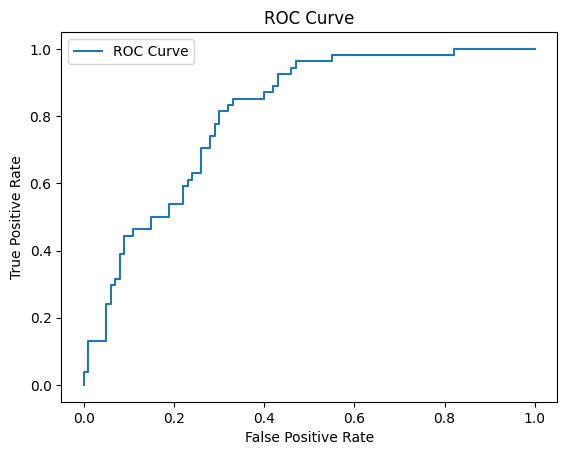

In [18]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()